# ECG GRU VAE

## Data load

In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import wfdb  # .dat 파일을 다루기 위한 라이브러리
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import random_split

class ECGDataset(Dataset):
    def __init__(self, base_directory):
        self.data = []
        self.labels = []
        self.classes = {d: idx for idx, d in enumerate(os.listdir(base_directory)) if os.path.isdir(os.path.join(base_directory, d))}
        
        for directory in self.classes.keys():
            frag_path = os.path.join(base_directory, directory, 'frag')
            if os.path.exists(frag_path):  # 'frag' 디렉토리가 존재하는지 확인
                for file in os.listdir(frag_path):
                    if file.endswith('.dat'):
                        self.data.append(os.path.join(frag_path, file))
                        self.labels.append(directory)
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # .dat 파일에서 ECG 신호를 불러오는 로직
        record = wfdb.rdrecord(os.path.splitext(self.data[idx])[0])
        ecg_signal = record.p_signal

        # 정규화 수행
        ecg_signal = self.normalization(ecg_signal)
        
        label = self.labels[idx]
        return ecg_signal, label
    
    def normalization(self, signal):
        max = signal.max()
        min = signal.min()
        return (signal - min) / (max - min)

# 상위 디렉토리 경로 설정
base_directory = './ecg-fragment-database-for-the-exploration-of-dangerous-arrhythmia-1.0.0'

# ECG Dataset 인스턴스 생성
ecg_dataset = ECGDataset(base_directory)

In [2]:
# 데이터셋의 전체 길이 확인
dataset_size = len(ecg_dataset)
print("데이터셋 크기:", dataset_size)

ecg_signal, label = ecg_dataset[0]
ecg_signal_size = len(ecg_signal)
print('신호 길이:', ecg_signal_size)

데이터셋 크기: 1016
신호 길이: 721


In [3]:
from collections import Counter

# 각 라벨의 발생 횟수를 카운트하기 위한 Counter 객체 생성
label_counts = Counter()

# 데이터셋 전체를 순회하며 각 라벨의 발생 횟수를 카운트
for _, label in ecg_dataset:
    label_counts[label] += 1

# 각 라벨별 개수 출력
for label, count in label_counts.items():
    print(f"{label}: {count}개")

1_Dangerous_VFL_VF: 337개
2_Special_Form_VTTdP: 72개
6_Sinus_rhythm: 200개
3_Threatening_VT: 169개
4_Potential_Dangerous: 132개
5_Supraventricular: 106개


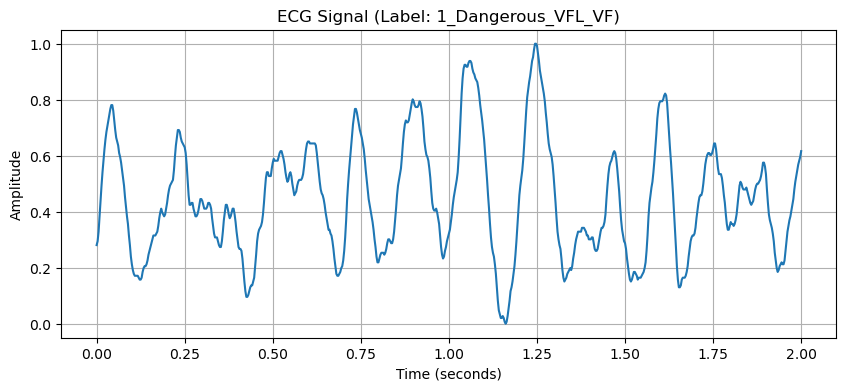

In [4]:
import matplotlib.pyplot as plt

# 샘플링 주파수
fs = 360

# 첫 번째 ECG 신호를 불러옵니다.
ecg_signal, label = ecg_dataset[0]

# 시간 축 생성
time_axis = [i / fs for i in range(len(ecg_signal))]

# ECG 신호 플롯
plt.figure(figsize=(10, 4))
plt.plot(time_axis, ecg_signal)
plt.title(f"ECG Signal (Label: {label})")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


In [5]:
# 데이터셋의 길이를 구합니다.
total_size = len(ecg_dataset)

# 훈련 세트와 테스트 세트의 크기를 정합니다. 여기서는 80:20 비율을 사용합니다.
train_size = int(total_size * 0.8)
test_size = total_size - train_size

# random_split을 사용하여 데이터셋을 나눕니다.
train_dataset, test_dataset = random_split(ecg_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

## GRU VAE

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [7]:
class GRUVAE(nn.Module):
    def __init__(self, latent_dim):
        super(GRUVAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.conv1_encoder = nn.Conv1d(1, 8, kernel_size=5, stride=2, padding=2)
        self.conv2_encoder = nn.Conv1d(8, 16, kernel_size=5, stride=2, padding=2)
        self.conv3_encoder = nn.Conv1d(16, 32, kernel_size=5, stride=2, padding=2)

        self.gru_encoder = nn.GRU(32, 64, batch_first=True)

        self.fc_mu = nn.Linear(64*91, latent_dim)
        self.fc_logvar = nn.Linear(64*91, latent_dim)

        # Decoder
        self.fc_decoder = nn.Linear(latent_dim, 64*91)
        
        self.conv1_decoder = nn.ConvTranspose1d(64, 32, kernel_size=5, stride=1, padding=2)
        self.conv2_decoder = nn.ConvTranspose1d(32, 16, kernel_size=5, stride=2, padding=2)
        self.conv3_decoder = nn.ConvTranspose1d(16, 8, kernel_size=5, stride=2, padding=2)
        self.conv4_decoder = nn.ConvTranspose1d(8, 1, kernel_size=5, stride=2, padding=2)


    def encode(self, x):
        x = x.permute(0, 2, 1)
        x = torch.tanh(self.conv1_encoder(x))
        x = torch.tanh(self.conv2_encoder(x))
        x = torch.tanh(self.conv3_encoder(x))

        x = x.permute(0, 2, 1)
        x, _ = self.gru_encoder(x)

        x = torch.flatten(x, start_dim=1)
        
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar


    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std


    def decode(self, z):
        z = torch.tanh(self.fc_decoder(z))

        z = z.view(-1, 64, 91)

        z = torch.tanh(self.conv1_decoder(z))
        z = torch.tanh(self.conv2_decoder(z))
        z = torch.tanh(self.conv3_decoder(z))
        output = self.conv4_decoder(z).permute(0, 2, 1)
        return output


    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar


# 손실 함수
def loss_function(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x, reduction='mean')
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + 0.001*KLD

In [8]:
# Parameters
latent_dim = 64

# 모델 및 최적화 알고리즘 설정
model = GRUVAE(latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 500

# 훈련 과정
def train(epoch):
    model.train()
    train_loss = 0
    
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.float()  # 데이터 타입을 모델에 맞게 조정
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)

        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        
        optimizer.step()

    print(f'Epoch[{epoch}/{num_epochs}] loss: {train_loss / len(train_loader.dataset):.8f}')


# 훈련 시작
for epoch in range(1, num_epochs + 1):
    train(epoch)

Epoch[1/500] loss: 0.01893270
Epoch[2/500] loss: 0.00628118
Epoch[3/500] loss: 0.00413341
Epoch[4/500] loss: 0.00363230
Epoch[5/500] loss: 0.00337634
Epoch[6/500] loss: 0.00329000
Epoch[7/500] loss: 0.00320994
Epoch[8/500] loss: 0.00315797
Epoch[9/500] loss: 0.00311053
Epoch[10/500] loss: 0.00301208
Epoch[11/500] loss: 0.00286295
Epoch[12/500] loss: 0.00247751
Epoch[13/500] loss: 0.00192530
Epoch[14/500] loss: 0.00158055
Epoch[15/500] loss: 0.00135794
Epoch[16/500] loss: 0.00119577
Epoch[17/500] loss: 0.00112979
Epoch[18/500] loss: 0.00102720
Epoch[19/500] loss: 0.00096702
Epoch[20/500] loss: 0.00092371
Epoch[21/500] loss: 0.00087247
Epoch[22/500] loss: 0.00083183
Epoch[23/500] loss: 0.00080680
Epoch[24/500] loss: 0.00077340
Epoch[25/500] loss: 0.00075200
Epoch[26/500] loss: 0.00073478
Epoch[27/500] loss: 0.00071482
Epoch[28/500] loss: 0.00070042
Epoch[29/500] loss: 0.00068460
Epoch[30/500] loss: 0.00067372
Epoch[31/500] loss: 0.00065938
Epoch[32/500] loss: 0.00064454
Epoch[33/500] los

In [9]:
def test():
    model.eval()  # 모델을 평가 모드로 설정
    test_loss = 0

    with torch.no_grad():  # 평가 중에는 기울기를 계산할 필요가 없습니다
        for data, _ in test_loader:
            data = data.float()  # 데이터 타입을 모델에 맞게 조정
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()

    test_loss /= len(test_loader.dataset)
    print(f'Test Set Loss: {test_loss:.8f}')

test()

Test Set Loss: 0.00032874


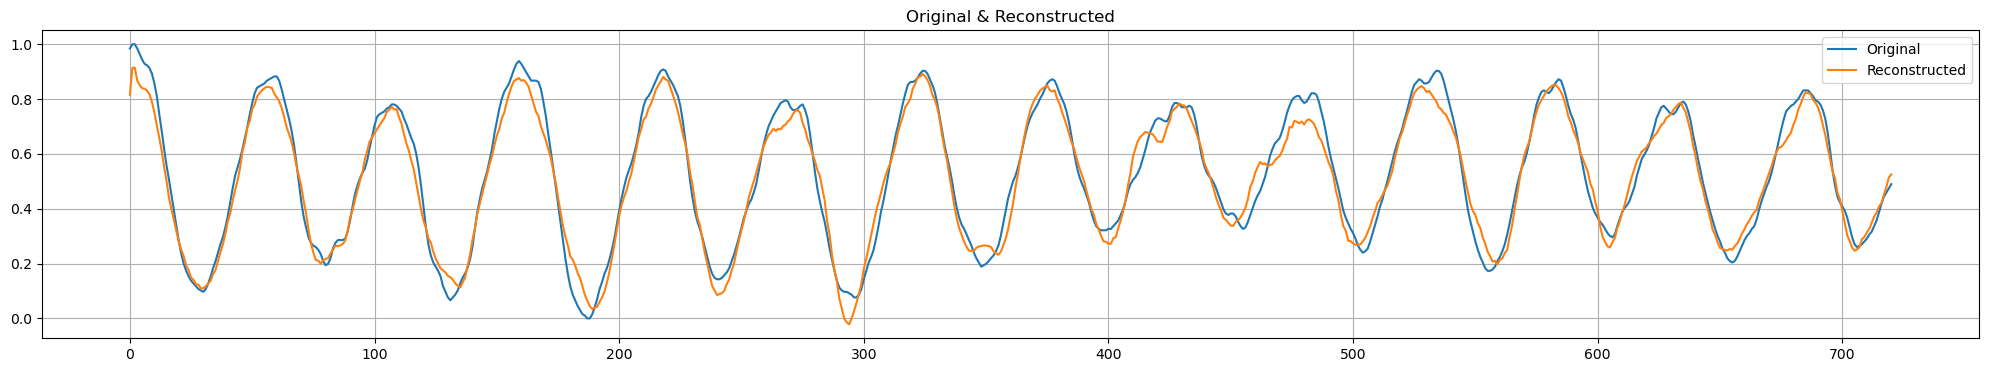

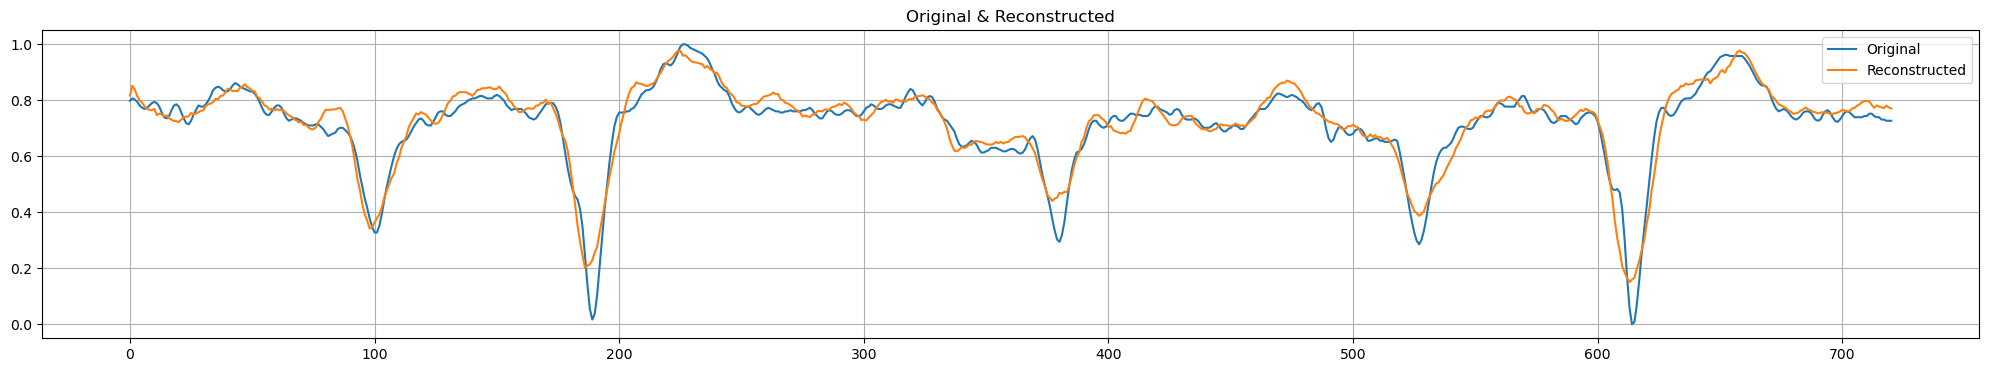

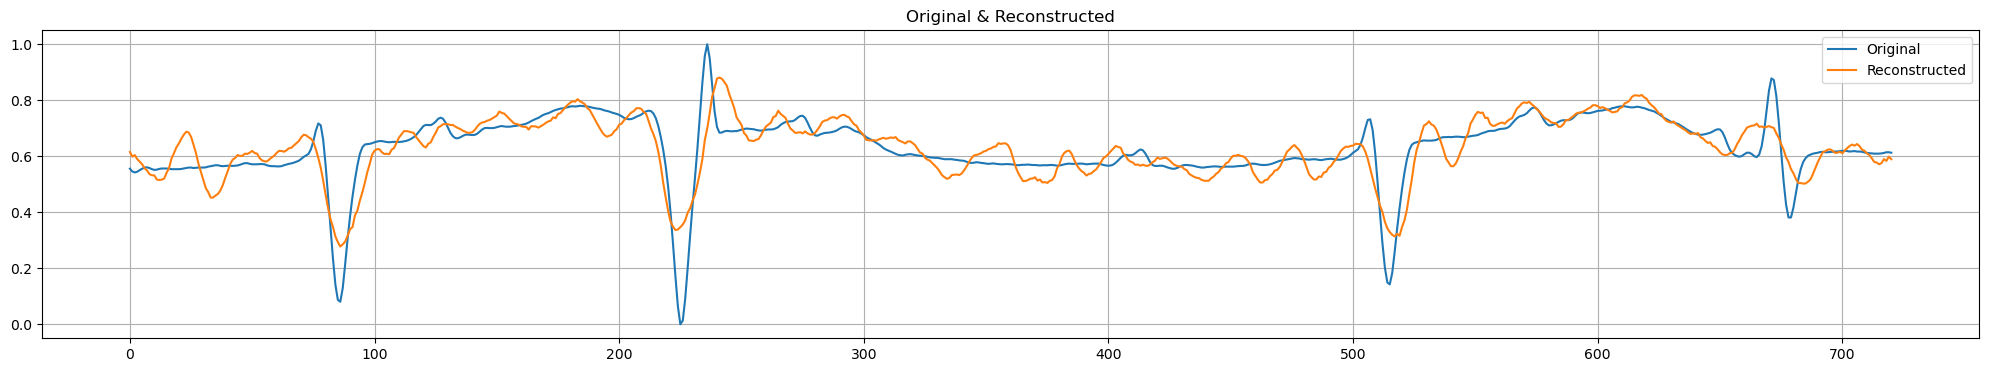

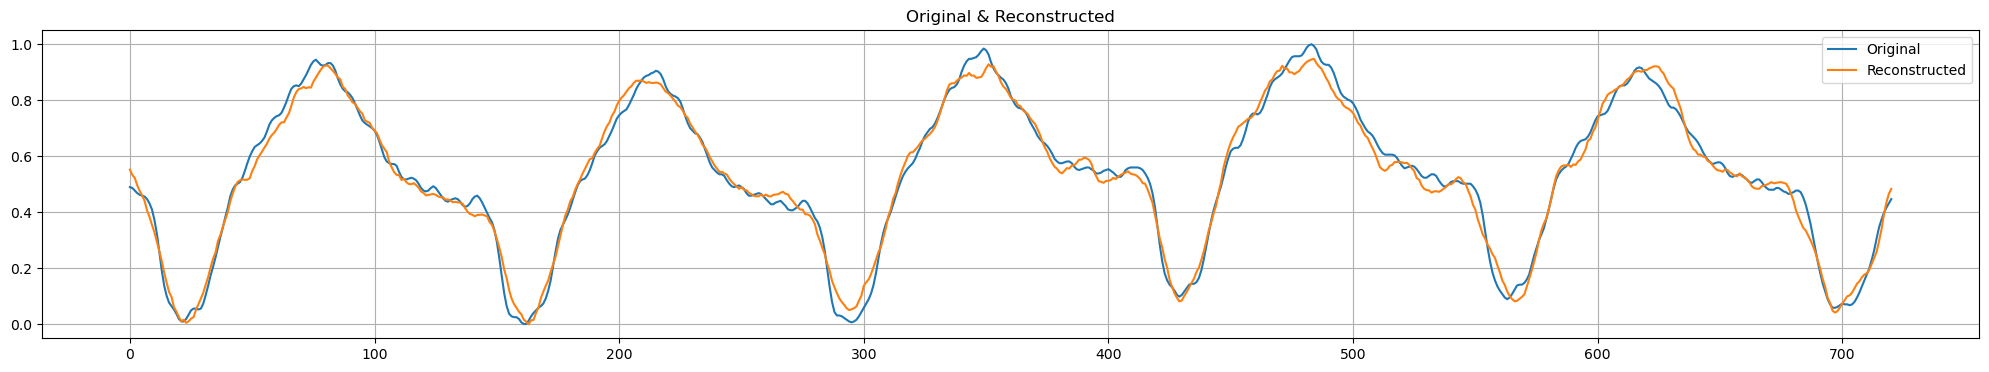

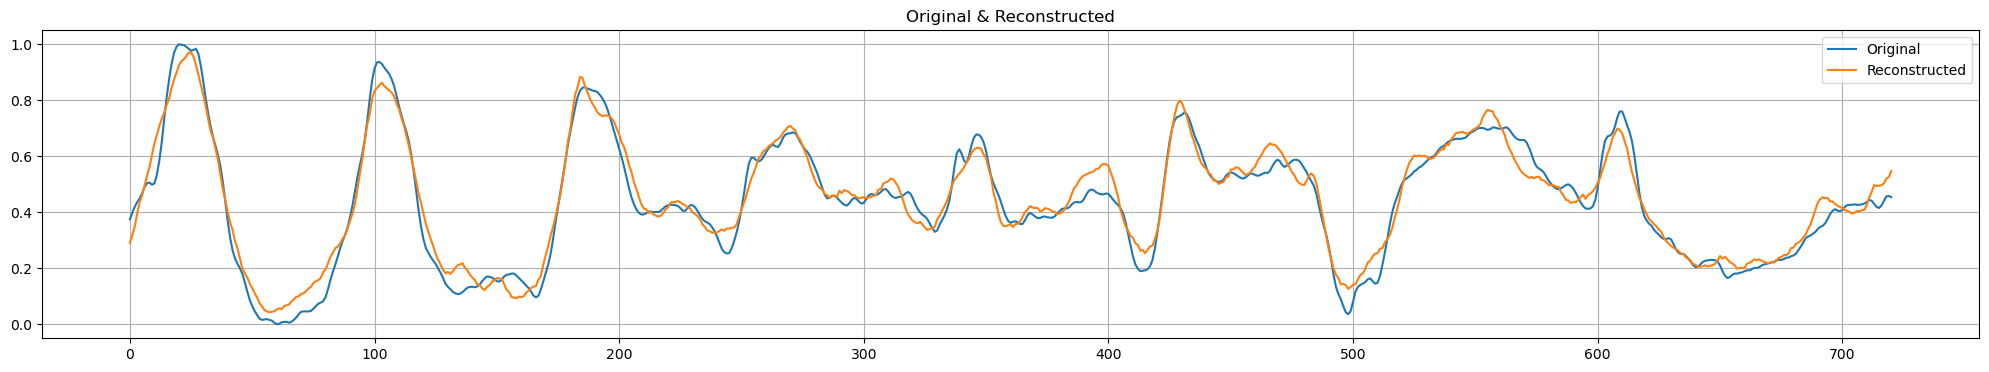

In [10]:
def visualize_reconstruction(model, data_loader, num_examples=5):
    for i, (data, labels) in enumerate(data_loader):
        if i >= num_examples:
            break
        with torch.no_grad():
            # 데이터를 모델 입력에 맞게 변환
            data = data.to(device).float()
            reconstructed, _, _ = model(data)

        plt.figure(figsize=(25, 4))
        plt.title('Original & Reconstructed')
        plt.plot((data[i].cpu().numpy().reshape(-1)), label='Original')
        plt.plot((reconstructed[i].cpu().numpy().reshape(-1)), label='Reconstructed')
        plt.legend()
        plt.grid()
    
    plt.show()

# 모델과 데이터 로더를 사용하여 시각화
visualize_reconstruction(model, test_loader)

---

아래는 latent dimension을 낮춰서 진행

In [11]:
# Parameters
latent_dim = 16

# 모델 및 최적화 알고리즘 설정
model = GRUVAE(latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 500

# 훈련 시작
for epoch in range(1, num_epochs + 1):
    train(epoch)

Epoch[1/500] loss: 0.00480507
Epoch[2/500] loss: 0.00423567
Epoch[3/500] loss: 0.00414638
Epoch[4/500] loss: 0.00353653
Epoch[5/500] loss: 0.00300892
Epoch[6/500] loss: 0.00283252
Epoch[7/500] loss: 0.00244352
Epoch[8/500] loss: 0.00196796
Epoch[9/500] loss: 0.00166307
Epoch[10/500] loss: 0.00149726
Epoch[11/500] loss: 0.00139396
Epoch[12/500] loss: 0.00131619
Epoch[13/500] loss: 0.00127670
Epoch[14/500] loss: 0.00124711
Epoch[15/500] loss: 0.00122597
Epoch[16/500] loss: 0.00121195
Epoch[17/500] loss: 0.00119932
Epoch[18/500] loss: 0.00118789
Epoch[19/500] loss: 0.00117880
Epoch[20/500] loss: 0.00117413
Epoch[21/500] loss: 0.00117011
Epoch[22/500] loss: 0.00116300
Epoch[23/500] loss: 0.00115709
Epoch[24/500] loss: 0.00115648
Epoch[25/500] loss: 0.00115334
Epoch[26/500] loss: 0.00114923
Epoch[27/500] loss: 0.00114580
Epoch[28/500] loss: 0.00114307
Epoch[29/500] loss: 0.00114134
Epoch[30/500] loss: 0.00113860
Epoch[31/500] loss: 0.00113967
Epoch[32/500] loss: 0.00113815
Epoch[33/500] los

In [12]:
test()

Test Set Loss: 0.00172741


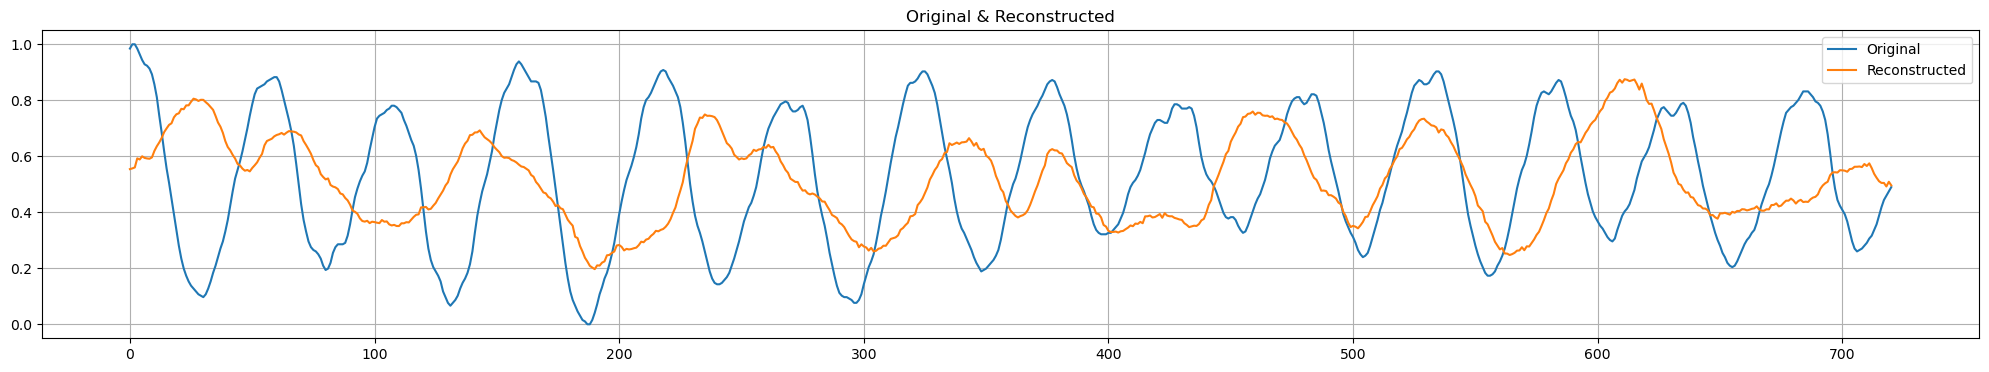

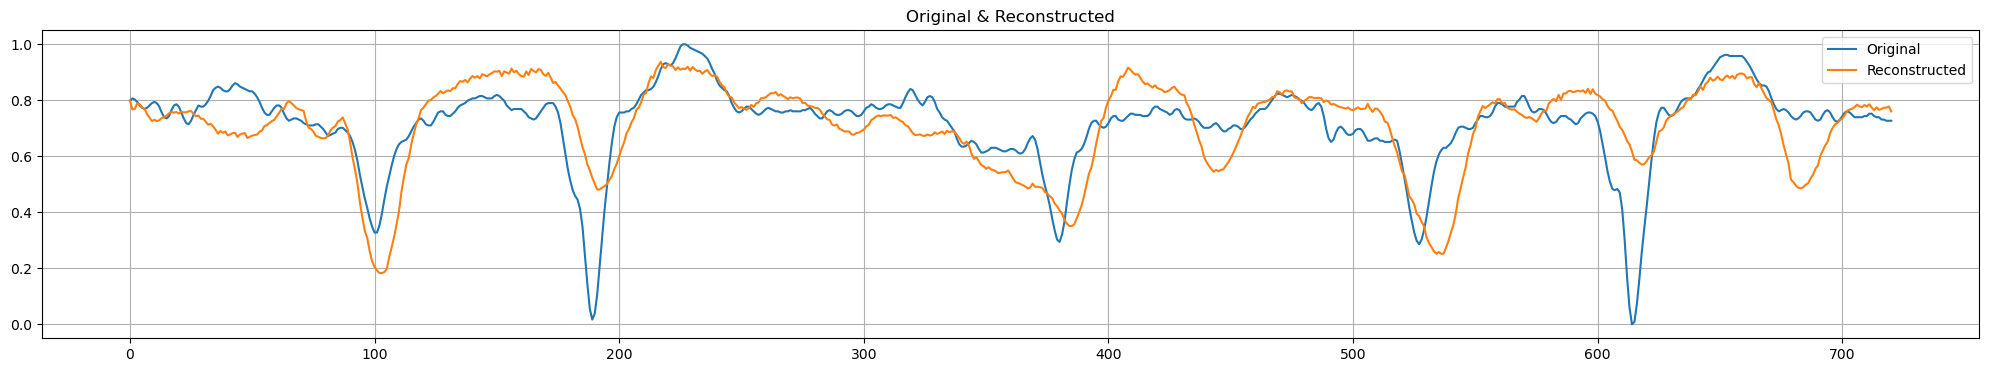

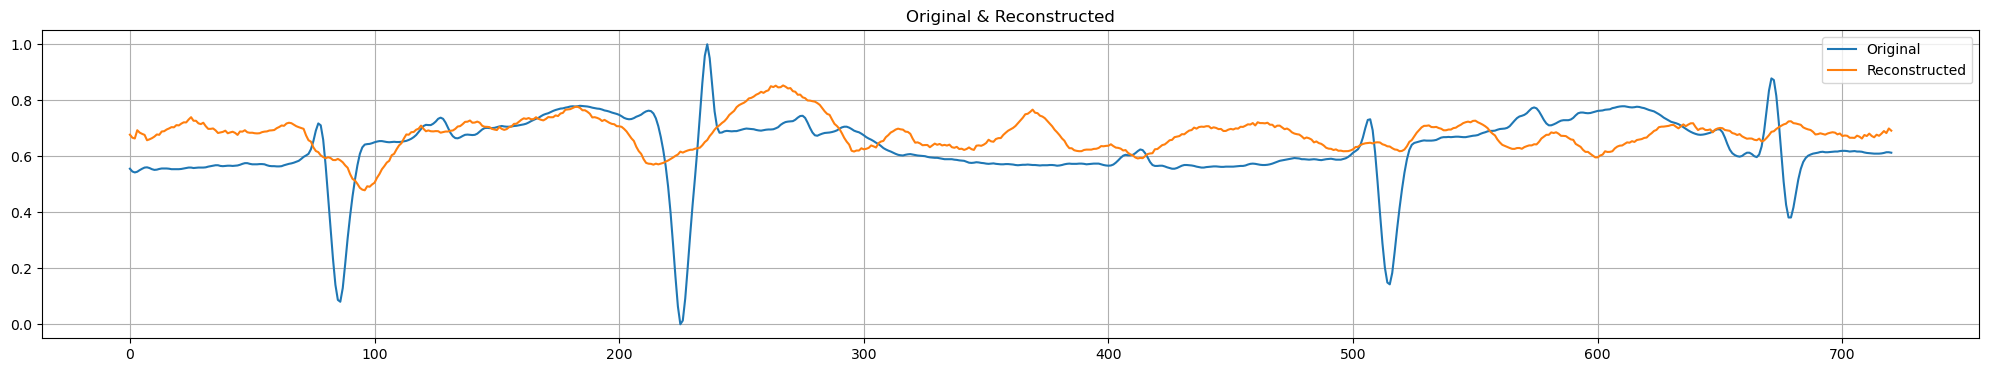

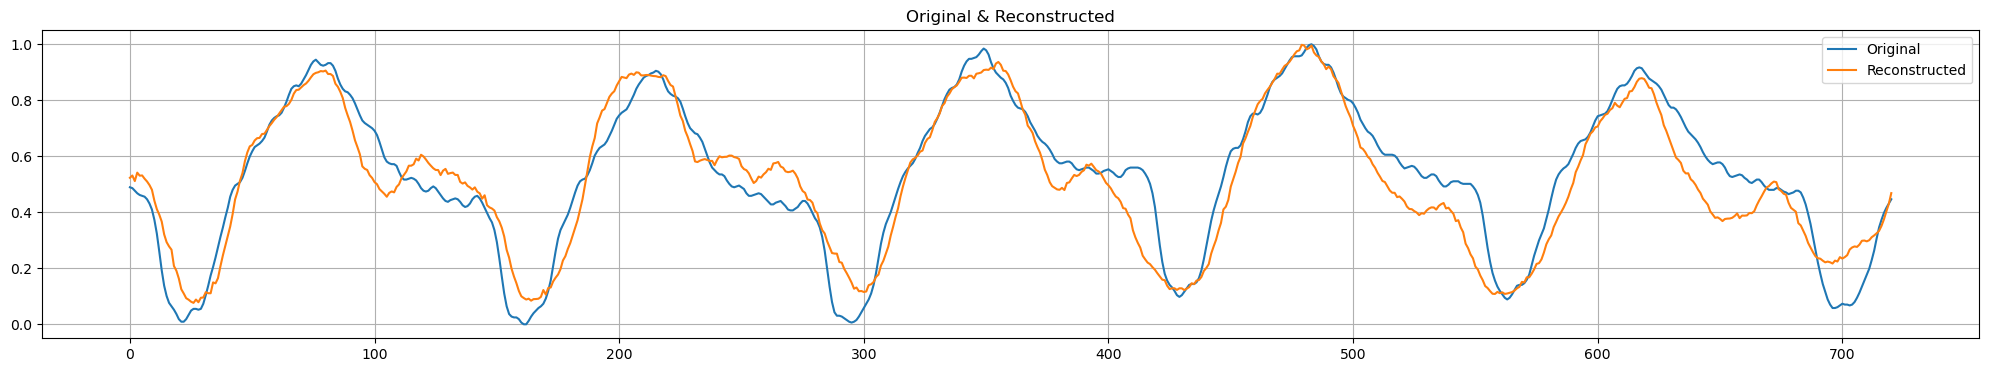

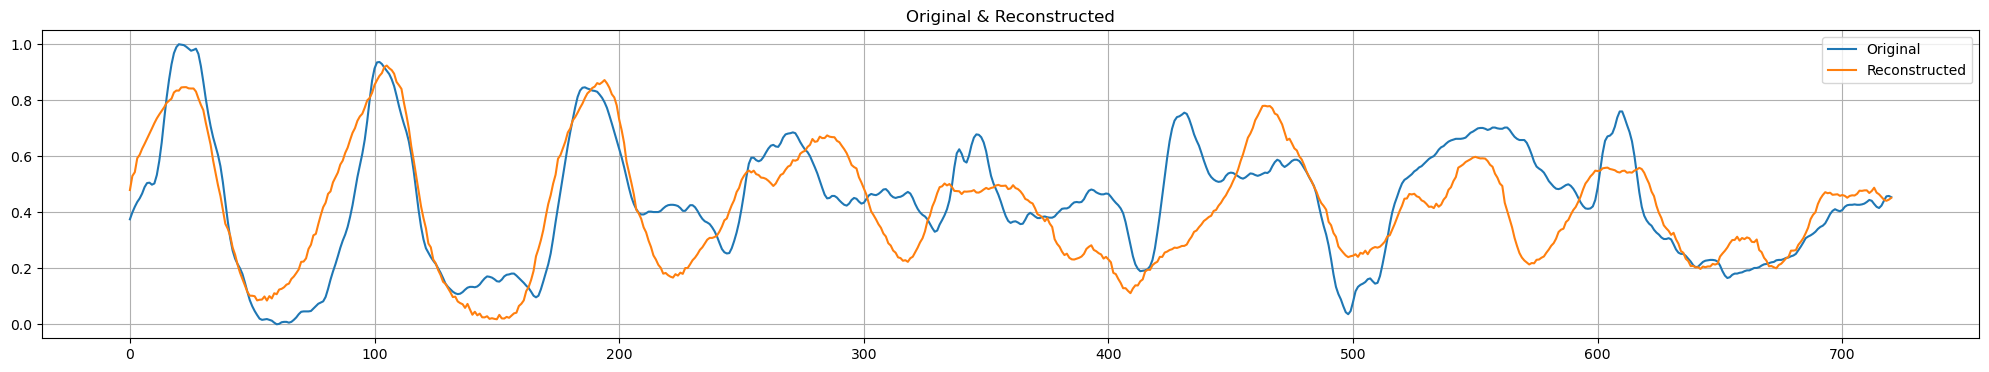

In [13]:
visualize_reconstruction(model, test_loader)